In [2]:
from ay_torch import *

# Nonlinear regression with Res blocks

In [3]:
FUNC_KIND=3
FUNC_KIND=5
def Func(x):
  #NOTE: Switch the function to be learned.
  global FUNC_KIND
  if FUNC_KIND==0:  return x
  if FUNC_KIND==1:  return (x[:,0]**2).reshape((-1,1))
  if FUNC_KIND==2:  return (3.0-x[:,0]).reshape((-1,1))
  if FUNC_KIND==3:  return (x[:,0]+3.0*np.sin(x[:,0])).reshape((-1,1))
  if FUNC_KIND==4:  return np.where(x[:,0]**2<1.0, 3.0, 0.0).reshape((-1,1))
  if FUNC_KIND==5:  return (3.0*(x[:,0]/2.5)+2.0*(x[:,0]/2.5)**2+1.0+3.0*np.cos(20.0*(x[:,0]/2.5))).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, f, noise=1.0e-10):
  data_x= np.random.uniform(xmin,xmax,size=(N_sample,1))
  data_y= f(data_x) + np.random.normal(scale=noise,size=(N_sample,1))
  return data_x,data_y

In [4]:
xmin,xmax= -5.0, 5.0
N_sample= 5000
#NOTE: Adjust the sample size and noise level.
data_x,data_y= GenerateSample(xmin, xmax, N_sample, Func, noise=0.5)

#Convert data to torch variables.
data_x= torch.autograd.Variable(torch.from_numpy(data_x).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch and epoch sizes.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x.shape[0])
N_train= round(data_x.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x[idxes[N_train:]], data_y[idxes[N_train:]])
dl_train= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)
dl_test= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
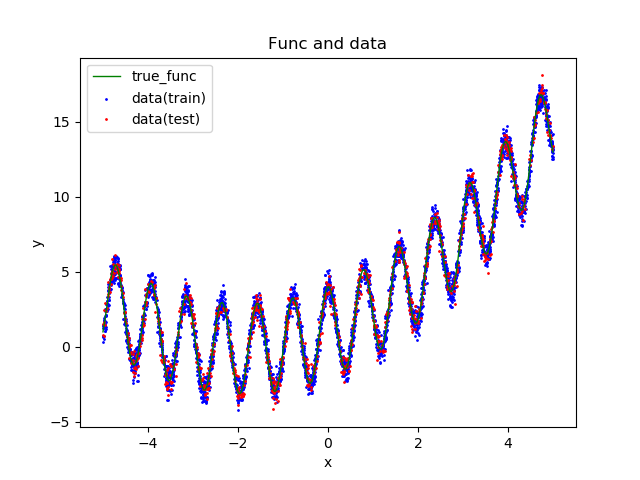

In [5]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
ax_pred.legend()

In [6]:
def DefRegNN6(p=0.0, n_hiddens=3):
  hiddens= sum([[torch.nn.Linear(200, 200),
                 torch.nn.ReLU()] for i in range(n_hiddens)],[])
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          *hiddens,
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )


def dense_layer_test(p=0.0, n_hiddens=3, **kwargs):
  hiddens= [DenseLayer(200, 200, **kwargs) for i in range(n_hiddens)]
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          *hiddens,
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )



class res_dense_net(torch.nn.Module):
  def __init__(self, in_channels, out_channels, p=0.0, hidden_channels=10, n_hiddens=3, **kwargs):
    super(res_dense_net,self).__init__()
    hiddens= [TResDenseBlock(hidden_channels, hidden_channels, **kwargs) for i in range(n_hiddens)]
    self.net= torch.nn.Sequential(
          torch.nn.Linear(in_channels, hidden_channels),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          *hiddens,
          torch.nn.Dropout(p),
          torch.nn.Linear(hidden_channels, out_channels),
          )
  def forward(self, x):
    return self.net(x)


In [7]:
# ConvLayer(3, 4, kernel_size=3)
DenseLayer(3,4,norm_type=None)

Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace=True)
)

In [22]:
#Setup a neural network.
net= DefRegNN6(n_hiddens=15, p=0.0)

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return torch.autograd.Variable(x), torch.autograd.Variable(y)
logger= TLogger()
disp= TDisp()

In [23]:
torchinfo.summary(net)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            400
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            40,200
├─ReLU: 1-5                              --
├─Linear: 1-6                            40,200
├─ReLU: 1-7                              --
├─Linear: 1-8                            40,200
├─ReLU: 1-9                              --
├─Linear: 1-10                           40,200
├─ReLU: 1-11                             --
├─Linear: 1-12                           40,200
├─ReLU: 1-13                             --
├─Linear: 1-14                           40,200
├─ReLU: 1-15                             --
├─Linear: 1-16                           40,200
├─ReLU: 1-17                             --
├─Linear: 1-18                           40,200
├─ReLU: 1-19                             --
├─Linear: 1-20                        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
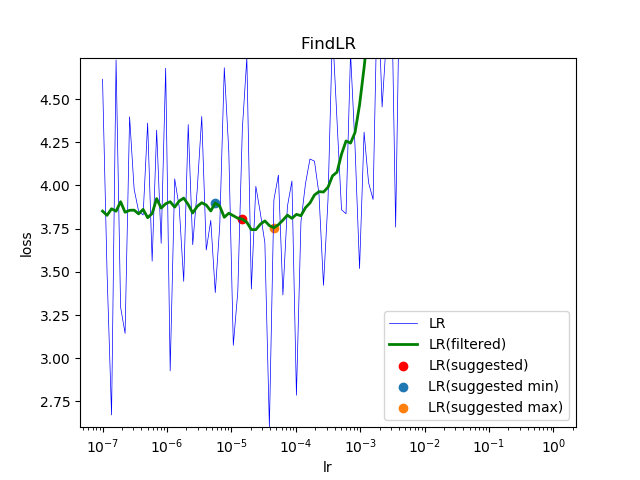

lr= 1.4791083881682072e-05, lr_min=5.62341325190349e-06, lr_max=4.57088189614875e-05


In [27]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
20	3.86609707	3.86650391	1.96304073	0.946128
21	3.87161180	3.87218239	1.96234040	0.913457
22	3.87157837	3.86255542	1.96054140	0.935060
23	3.87235312	3.86687401	1.96139291	0.909420
24	3.87706640	3.89986538	1.97010622	0.932000
25	3.91986977	3.92512793	1.97685438	0.921202
26	3.88508931	3.89434882	1.96911606	0.925450
27	3.87434017	3.87226356	1.96352464	0.902563
28	3.86417664	3.85053846	1.95879043	0.910226
29	3.86161512	3.85037665	1.95532559	0.942697
30	3.86031651	3.84940758	1.95750923	0.907670
31	3.85251770	3.85598485	1.95945666	0.902993
32	3.86930829	3.84390057	1.95576458	0.928979
33	3.85181551	3.84540107	1.95659898	0.899971
34	3.85264815	3.84557267	1.95589655	0.896019
35	3.84861982	3.84115353	1.95611792	0.928594
36	3.84516212	3.84108994	1.95547348	0.914415
37	3.84295221	3.84054561	1.95538200	0.897311
38	3.84217586	3.84059623	1.95606406	0.896609
39	3.84062320	3.84048399	1.95402347	0.883309


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
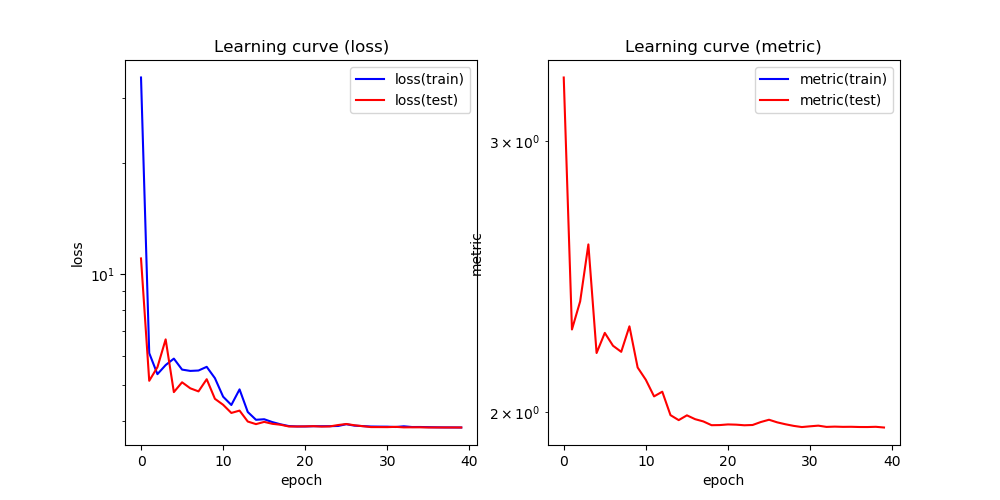

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
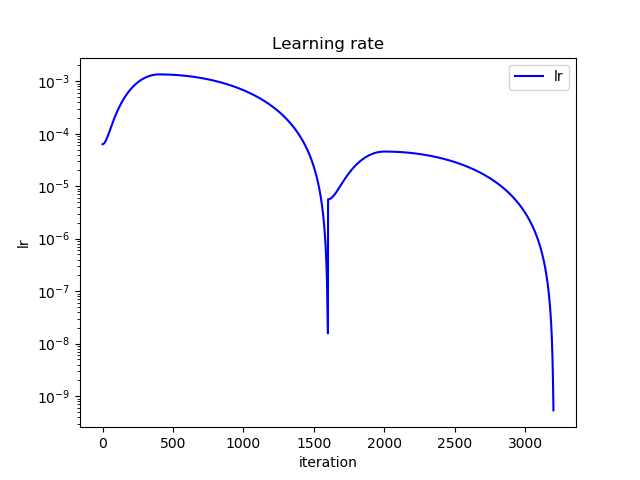

In [28]:
FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
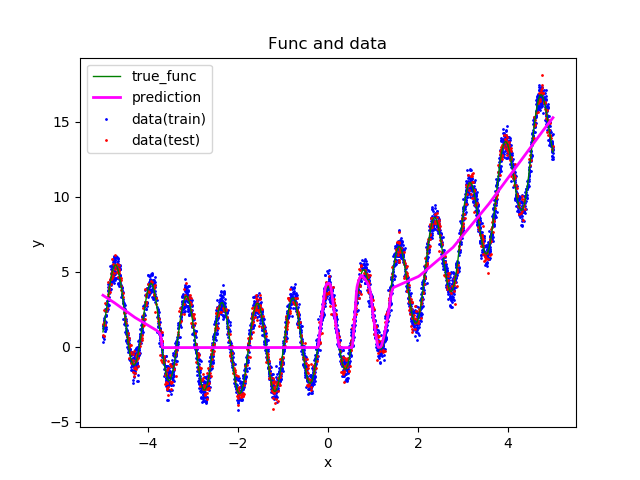

In [29]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
pred_y= decode(Eval(net, torch.from_numpy(true_x).float(), device=device)).cpu()
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
ax_pred.plot(true_x, pred_y, color='magenta', linewidth=2, label='prediction')
ax_pred.legend()

In [30]:
#Setup a neural network.
# net= dense_layer_test(init='auto', bias_std=0.5)
# net= dense_layer_test(n_hiddens=10)
# net= res_dense_net(1, 1, hidden_channels=10)
# net= res_dense_net(1, 1, hidden_channels=100)
net= res_dense_net(1, 1, hidden_channels=200, n_hiddens=10, p=0.0)
# net= res_dense_net(1, 1, hidden_channels=200, n_hiddens=10, p=0.0, norm_type=None)

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return torch.autograd.Variable(x), torch.autograd.Variable(y)
logger= TLogger()
disp= TDisp()

In [31]:
# net
torchinfo.summary(net)

Layer (type:depth-idx)                        Param #
res_dense_net                                 --
├─Sequential: 1-1                             --
│    └─Linear: 2-1                            400
│    └─ReLU: 2-2                              --
│    └─Dropout: 2-3                           --
│    └─TResDenseBlock: 2-4                    --
│    │    └─Sequential: 3-1                   81,200
│    │    └─Sequential: 3-2                   --
│    │    └─LeakyReLU: 3-3                    --
│    └─TResDenseBlock: 2-5                    --
│    │    └─Sequential: 3-4                   81,200
│    │    └─Sequential: 3-5                   --
│    │    └─LeakyReLU: 3-6                    --
│    └─TResDenseBlock: 2-6                    --
│    │    └─Sequential: 3-7                   81,200
│    │    └─Sequential: 3-8                   --
│    │    └─LeakyReLU: 3-9                    --
│    └─TResDenseBlock: 2-7                    --
│    │    └─Sequential: 3-10                  81,20

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
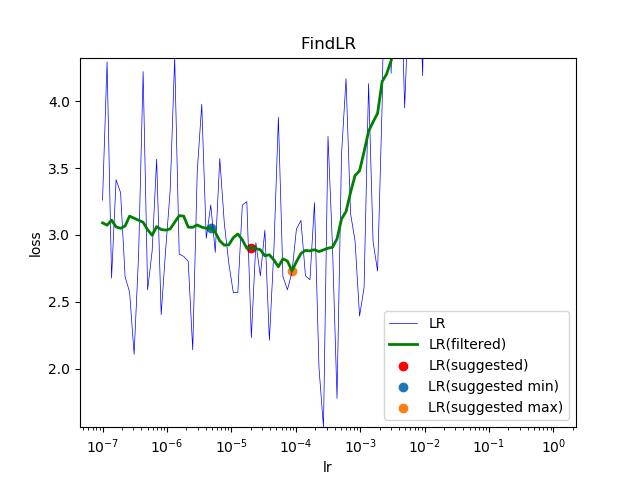

lr= 2.0417379446695298e-05, lr_min=4.7863009232263826e-06, lr_max=8.709635899560804e-05


In [35]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
40	1.98377306	1.60739929	1.25925952	1.473277
41	2.04966038	1.55508909	1.24081334	1.425424
42	2.02522546	1.91418672	1.37635119	1.360171
43	1.90954939	2.16329181	1.46231806	1.408717
44	2.00885080	1.16786617	1.07485255	1.448789
45	2.09099777	1.71881768	1.30316332	1.391400
46	1.96546248	1.81754631	1.34207344	1.424369
47	1.91672160	1.50906343	1.22102669	1.388266
48	1.65838262	1.57858029	1.24935740	1.437787
49	1.56621698	1.09554382	1.03488156	1.394166
50	1.37003294	1.49322245	1.20662014	1.398242
51	1.23721100	0.67341852	0.81622680	1.396577
52	1.23878873	1.95822681	1.38806812	1.421302
53	1.08135813	0.80455401	0.89308164	1.410877
54	0.93515280	0.74455402	0.85744165	1.414958
55	0.89137751	0.46604982	0.67874914	1.440470
56	0.81009798	0.52741242	0.72161445	1.421335
57	0.78174034	0.76151784	0.86200554	1.480432
58	0.79291682	0.55181949	0.73848099	1.446390
59	0.73828786	0.49520221	0.70065631	1.413750


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
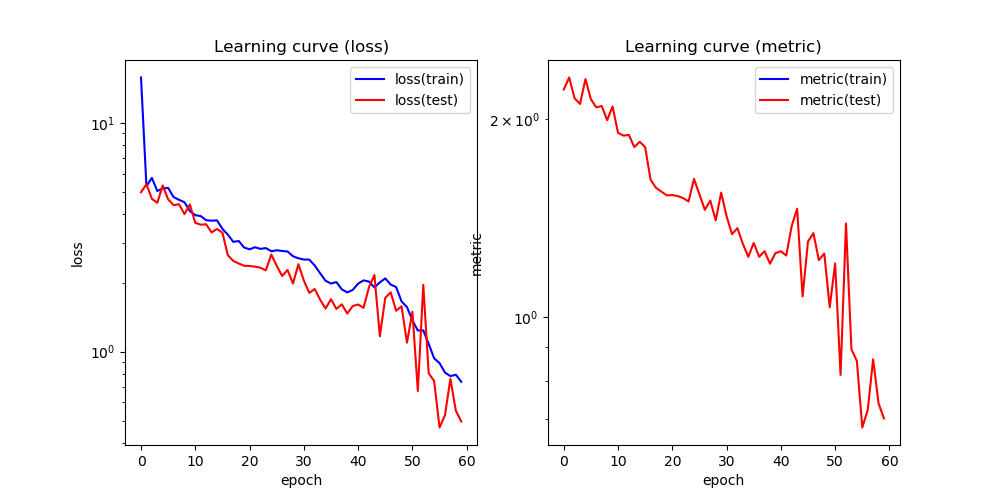

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
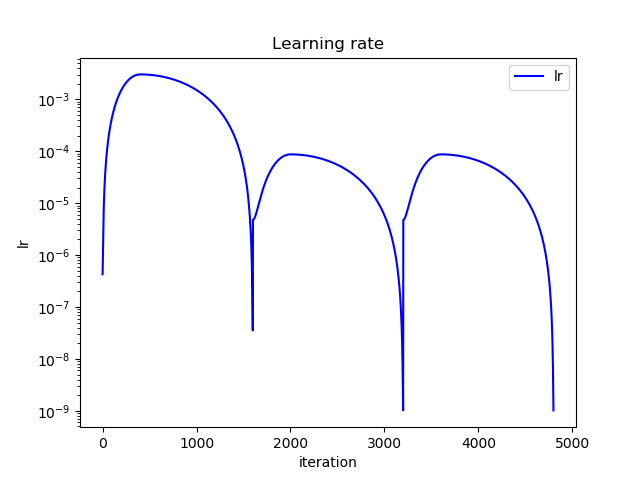

In [38]:
FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
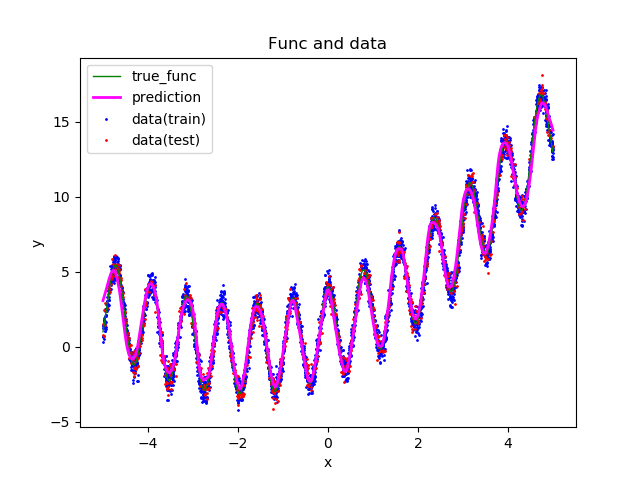

In [39]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
pred_y= decode(Eval(net, torch.from_numpy(true_x).float(), device=device)).cpu()
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
ax_pred.plot(true_x, pred_y, color='magenta', linewidth=2, label='prediction')
ax_pred.legend()